In [148]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 6)

sns.set_style("whitegrid")

PATH  = "../Networks/"

In [4]:
dir_reg   = re.compile(r'.*Networks/(.+)_Student_Networks/saved/(student_\d)_([^\/]+)\/(.+)')
err_reg   = re.compile(r'Err:  (\d\.\d+)')

series = {}

for dirpath, dirnames, filenames in os.walk(PATH):

    mtch    = dir_reg.match(dirpath)

    if mtch:

        try:
            with open(dirpath+"/log.txt", "r") as f:
                raw_log = f.readlines()

            dataset, net, config, algo = mtch.group(1), mtch.group(2), mtch.group(3), mtch.group(4)

            if dataset not in series:
                series[dataset] = {}

            if net not in series[dataset]:
                series[dataset][net] = {}

            if config not in series[dataset][net]:
                series[dataset][net][config] = []

            err = pd.Series(err_reg.findall(" ".join(raw_log)), dtype=float)
            
            series[dataset][net][config].append((algo, err))

        except IOError:
            print dirpath, "has no log file."

In [27]:
df    = pd.DataFrame()

for dataset in ["CIFAR_10", "Top_Down"]:
    for net in series[dataset].keys():
        for config in series[dataset][net].keys():
            for algo, data in series[dataset][net][config]:
                col_name = "{0} {1} {2} {3}".format(dataset, net, config, algo)
                df[col_name] = data
                
df.columns

Index([u'CIFAR_10 student_1 N2_H32 reg_logits',
       u'CIFAR_10 student_1 N2_H32 know_dist_T5.0_beta0.05',
       u'CIFAR_10 student_1 N2_H32 baseline',
       u'CIFAR_10 student_1 N2_H64 reg_logits',
       u'CIFAR_10 student_1 N2_H64 know_dist_T5.0_beta0.05',
       u'CIFAR_10 student_1 N2_H64 baseline',
       u'CIFAR_10 student_1 N1_H32 reg_logits',
       u'CIFAR_10 student_1 N1_H32 know_dist_T5.0_beta0.05',
       u'CIFAR_10 student_1 N1_H32 baseline',
       u'Top_Down student_1 7_10 reg_logits',
       u'Top_Down student_1 7_10 know_dist_T5.0_beta0.05',
       u'Top_Down student_1 7_10 baseline',
       u'Top_Down student_1 15_20 reg_logits',
       u'Top_Down student_1 15_20 know_dist_T5.0_beta0.05',
       u'Top_Down student_1 15_20 baseline',
       u'Top_Down student_1 10_15 reg_logits',
       u'Top_Down student_1 10_15 know_dist_T5.0_beta0.05',
       u'Top_Down student_1 10_15 baseline',
       u'Top_Down student_2 18 baseline_hint_based',
       u'Top_Down student_2 1

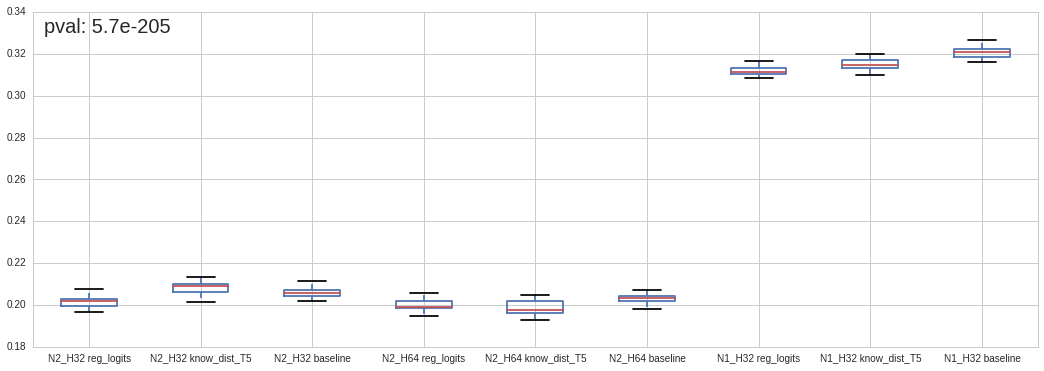

In [217]:
reg = re.compile(r'CIFAR_10 student_1 (\w+ \w+).*')

df1 = df[[col for col in df.columns if reg.match(col)]].copy()
df1.columns = [reg.match(col).group(1) for col in df1.columns]

from scipy.stats import f_oneway
f_score, p_val = f_oneway(*[df1[col] for col in df1.columns])

ax = df1.iloc[80:].boxplot()

ax.annotate('pval: {0:.2g}'.format(p_val), (0.6,0.33), fontsize=20)

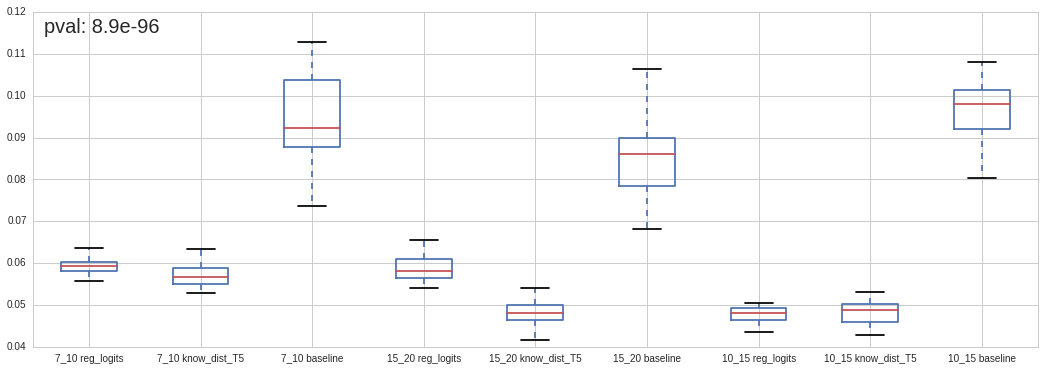

In [219]:
reg = re.compile(r'Top_Down student_1 (\w+ \w+).*')

df1 = df[[col for col in df.columns if reg.match(col)]].copy()
df1.columns = [reg.match(col).group(1) for col in df1.columns]

from scipy.stats import f_oneway
f_score, p_val = f_oneway(*[df1[col] for col in df1.columns])

ax = df1.iloc[80:].boxplot()

ax.annotate('pval: {0:.2g}'.format(p_val), (0.6,0.115), fontsize=20)

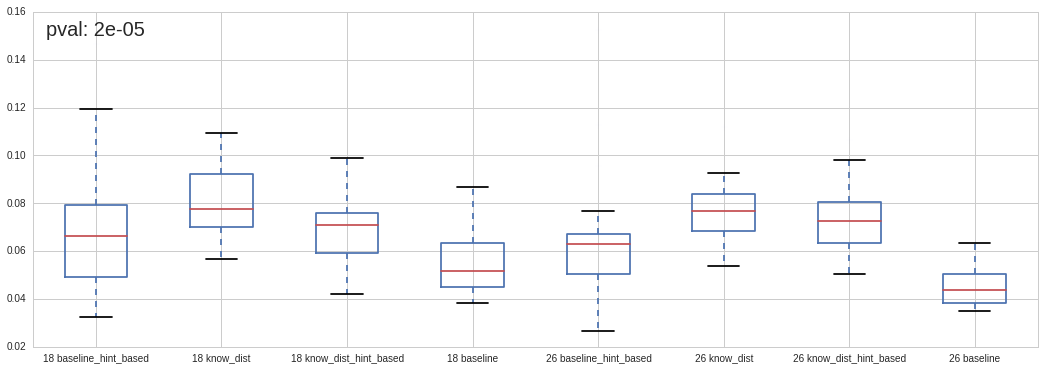

In [220]:
reg = re.compile(r'Top_Down student_2 (\w+ \w+).*')

df1 = df[[col for col in df.columns if reg.match(col)]].copy()
df1.columns = [reg.match(col).group(1) for col in df1.columns]

from scipy.stats import f_oneway
f_score, p_val = f_oneway(*[df1[col] for col in df1.columns])

ax = df1.iloc[80:].boxplot()

ax.annotate('pval: {0:.2g}'.format(p_val), (0.6,0.15), fontsize=20)